In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import STL
from datetime import datetime

# Reading and preparing data

In [2]:
# Read data
df_fact = pd.read_csv('Fact_Measurements.csv')

In [3]:
# Fix fact sheet
df_fact = df_fact.iloc[1: , :]
df_fact = df_fact.drop('IsGrandTotalRowTotal',axis=1)

In [4]:
# Change Date and Time to datetime objects
df_fact['Time'] = df_fact['Time'].str.split().str[1]
df_fact['Date'] = df_fact['Date'].str.split().str[0]
df_fact['datetime'] = df_fact['Date'] + df_fact['Time']
df_fact['datetime'] = pd.to_datetime(df_fact['datetime'], format="%Y-%m-%d%H:%M:%S.%f")
df_fact["Time"] = (pd.to_datetime(df_fact["Time"])).dt.strftime("%H:%M")

In [5]:
# Fix dim sheet
df_dim = pd.read_csv('Dim_DevicesAndBuildings.csv')
df_dim = df_dim.iloc[1: , :]
df_dim = df_dim.drop('IsGrandTotalRowTotal',axis=1).drop('Målertype',axis=1)

In [6]:
# Merge data
df = pd.merge(left=df_fact,right=df_dim,how='inner')

In [7]:
# Data cleaning - energy types and measurement types don't match
df = df.drop(df[(df['Energinavn']=='Varme') & (df['Enhed']!='MWh')].index)
df = df.drop(df[(df['Energinavn']=='Elektricitet') & (df['Enhed']!='kWh')].index)
df = df.drop(df[(df['Energinavn']=='Vand') & (df['Enhed']!='m3')].index)

In [8]:
# Subset data using heating data from building 3130  
data = df[(df['Bygningsnavn']==3130.0) & (df['Energinavn']=='Varme')]
data = data.drop(['SumNettoareal','Bygningsnavn','Enhed'],axis=1)
data = data.groupby('Date').mean()
data = data.asfreq(pd.infer_freq(data.index))
data.head()

,SumMåling
Date,
2018-08-30,0.028748
2018-08-31,0.033753
2018-09-01,0.024170
2018-09-02,0.025838
2018-09-03,0.024170


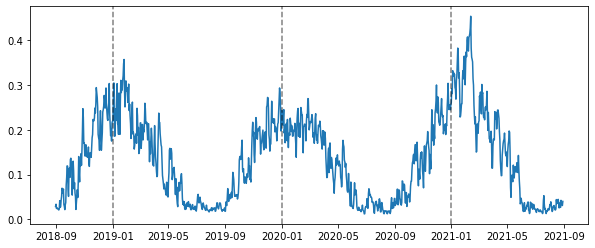

In [9]:
# Plot data with lines indicating each year
plt.figure(figsize=(10,4))
plt.plot(data)
for year in range(2019,2022):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

# Seasonal decomposition

In [10]:
stl = STL(data, period=365)
result = stl.fit()

In [11]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

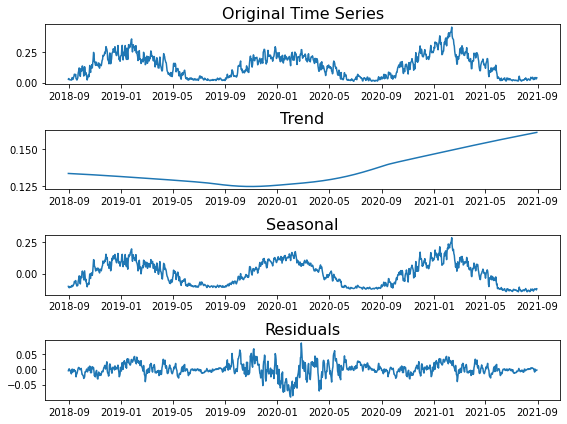

In [12]:
# Plotting STL data
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(data)
plt.title('Original Time Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residuals', fontsize=16)

plt.tight_layout()

# Anomaly detection

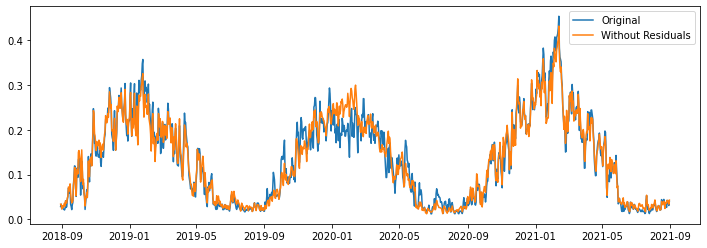

In [13]:
# Plot comparing time series with and without residuals
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(data,label='Original')
plt.plot(estimated, label='Without Residuals')
plt.legend()

In [14]:
resid_mean = resid.mean()
resid_std = resid.std()

lower = resid_mean - 2*resid_std
upper = resid_mean + 2*resid_std

(17775.0, 18870.0)

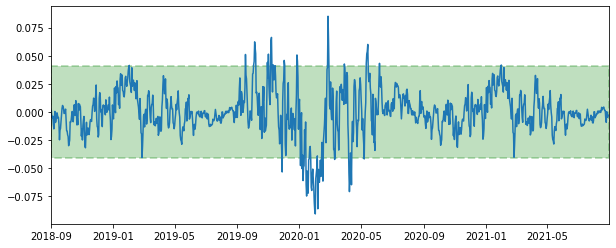

In [15]:
# Plot showing residuals and +/- 2 standard deviations in green
plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,9,1), datetime(2021,8,31)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2021,8,31))

In [16]:
anomalies = data[(resid < lower) | (resid > upper)]

In [17]:
anomalies

,SumMåling
Date,
2019-02-01,0.285420
2019-09-17,0.105001
2019-10-03,0.140829
2019-10-04,0.133749
2019-10-05,0.137920
...,...
2020-05-13,0.166666
2020-05-14,0.162089
2020-06-06,0.081665


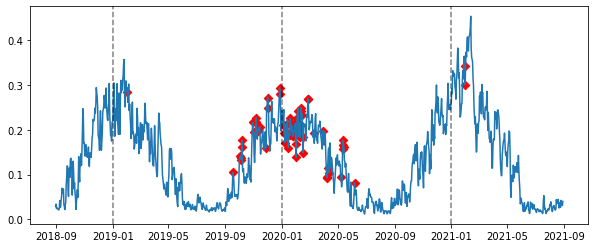

In [18]:
plt.figure(figsize=(10,4))
plt.plot(data)
for year in range(2019,2022):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.SumMåling, color='r', marker='D')

Anomalies here are still mostly due to weather, as the winter of 19/20 was relatively mild. Hence the lower energy consumption.